<a href="https://colab.research.google.com/github/thyeaditungson29/mystudy_ADL2022/blob/main/UTS_ADL_Thyeadi_Tungson_(2nd_version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **UTS Applied Deep Learning**


* Project: XNet: A convolutional neural network (CNN) implementation for medical X-Ray image segmentation suitable for small datasets

* Paper: https://paperswithcode.com/paper/xnet-a-convolutional-neural-network-cnn

* XNet Model: https://github.com/JosephPB/XNet


* Data: https://www.kaggle.com/datasets/nikhilpandey360/chest-xray-masks-and-labels



# **0. Unduh dan Inisialisasi Library yang digunakan**

*Unduh Beberapa Library penting*

In [1]:
# !pip install -q matplotlib==3.0.2
!pip install -q tensorflow
!pip install -U -q tensorflow-addons

     |████████████████████████████████| 462 kB 12.4 MB/s 


In [2]:
#Inisialisasi Libarary Umum
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline
import os
from tqdm import tqdm
import cv2
import random
import warnings
warnings.filterwarnings("ignore")

# Inisialisasi Library untuk Model
import tensorflow as tf
import tensorflow_addons as tfa
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint

# **1. Mengambil dan Menyiapkan Dataset dari Kaggle**

*1.1. Mengambil Dataset*

In [3]:
#Data diambil dari kaggle, oleh karena itu perlu menautkan kaggle dengan colabs
!pip install -q kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"thyeaditungson29","key":"dba4278816cf1a21a33350216eb24964"}'}

In [5]:
# copy file kaggle.json ke folder dimana API dapat menemukannya.
!mkdir -p ~/.kaggle/ && cp kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Unduh dataset
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

100% 9.58G/9.58G [02:34<00:00, 109MB/s]
100% 9.58G/9.58G [02:34<00:00, 66.4MB/s]


In [9]:
#Ekstrak file ZIP dataset
!unzip -q chest-xray-masks-and-labels.zip

*Menyiapkan Dataset*

In [10]:
# Lokasi dari tiap Dataset
image_path_train = '/content/Lung Segmentation/CXR_png'
mask_path_train = '/content/Lung Segmentation/masks/'
image_path_test = '/content/Lung Segmentation/test/' 

In [11]:
images = os.listdir(image_path_train)
mask = os.listdir(mask_path_train)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [12]:
check = [i for i in mask if "mask" in i]
print("Total label(mask) yang sudah dimodifikasi nama:", len(check))

Total label(mask) yang sudah dimodifikasi nama: 566


In [13]:
testing_files = set(os.listdir(image_path_train)) & set(os.listdir(mask_path_train))
training_files = check

In [14]:
def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    shape = (X_shape, X_shape)
    # X_shape = image_size
    if flag == "test":
        for i in tqdm(testing_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i), cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im, shape)
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, shape)
            
            im_array.append(im)
            mask_array.append(mask)
    
    if flag == "train":
        for i in tqdm(training_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i.split("_mask")[0] + ".png"), cv2.IMREAD_GRAYSCALE)
            im = cv2.resize(im, shape)
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i + ".png"), cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, shape)
            
            im_array.append(im)
            mask_array.append(mask)
    # return list
    return im_array, mask_array

In [15]:
def get_test(X_shape, n_samples = 100):
    im_array = []
    shape = (X_shape, X_shape)
    test_files = random.choices(list(os.listdir(image_path_test)), k=n_samples)
    for i in tqdm(test_files):
        im = cv2.imread(os.path.join(image_path_test, i), cv2.IMREAD_GRAYSCALE)
        im = cv2.resize(im, shape)
        im = cv2.equalizeHist(im)
        im_array.append(im)
    return im_array

# **2. Memuat Image dan Label(Mask)**

In [16]:
dim, n_samples = 256, 50 # n_samples = [1, 96]

image_train, mask_train = getData(dim, flag = "train")
image_test, mask_test = getData(dim, flag = "test")
X_test = get_test(dim, n_samples = n_samples)

100%|██████████| 50/50 [00:09<00:00,  5.45it/s]


In [17]:
image_train = np.array(image_train).reshape(len(image_train), dim, dim, 1)
mask_train = np.array(mask_train).reshape(len(mask_train), dim, dim, 1)

image_test = np.array(image_test).reshape(len(image_test), dim, dim, 1)
mask_test = np.array(mask_test).reshape(len(mask_test), dim, dim, 1)

X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)

In [18]:
print('Dimensi/Ukuran dari Image Train: ',image_train.shape,'\nDimensi/Ukuran dari Label(Mask) train: ' ,mask_train.shape)
print('\nDimensi/Ukuran dari Image Test: ',image_test.shape,'\nDimensi/Ukuran dari Label(Mask) test: ' ,mask_test.shape)
print('\nDimensi/Ukuran dari X Test: ',X_test.shape)

Dimensi/Ukuran dari Image Train:  (566, 256, 256, 1) 
Dimensi/Ukuran dari Label(Mask) train:  (566, 256, 256, 1)

Dimensi/Ukuran dari Image Test:  (138, 256, 256, 1) 
Dimensi/Ukuran dari Label(Mask) test:  (138, 256, 256, 1)

Dimensi/Ukuran dari X Test:  (50, 256, 256, 1)


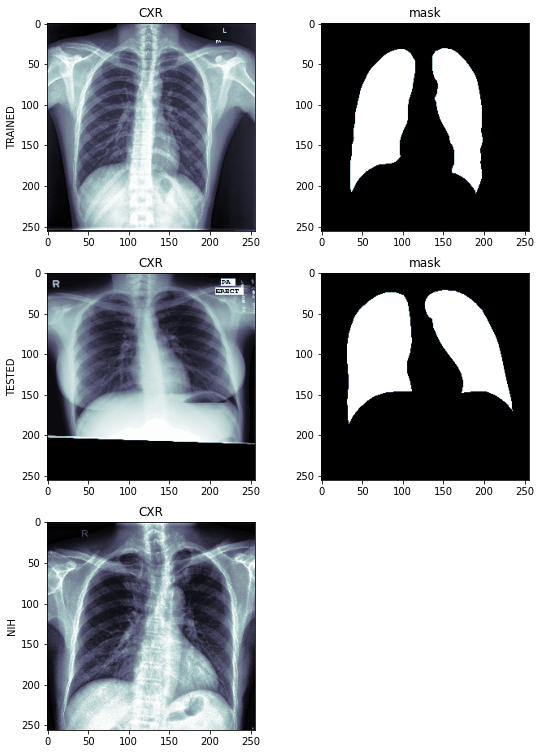

In [59]:
i = 13
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 13))
axs[0, 0].imshow(image_train[i].reshape(256,256), cmap='bone')
axs[0, 1].imshow(mask_train[i].reshape(256,256), cmap='bone')
axs[0, 0].set_ylabel('TRAINED')

axs[1, 0].imshow(image_test[i].reshape(256,256), cmap='bone')
axs[1, 1].imshow(mask_test[i].reshape(256,256), cmap='bone')
axs[1, 0].set_ylabel('TESTED')

axs[2, 0].imshow(X_test[i].reshape(256,256), cmap='bone')
axs[2, 0].set_ylabel('NIH')

axs[0, 0].set_title('CXR')
axs[1, 0].set_title('CXR')
axs[2, 0].set_title('CXR')

axs[0, 1].set_title('mask')
axs[1, 1].set_title('mask')

fig.delaxes(axs[2, 1])

In [20]:
assert image_train.shape == mask_train.shape
assert image_test.shape == mask_test.shape
images = np.concatenate((image_train, image_test), axis=0)
masks  = np.concatenate((mask_train, mask_test), axis=0)

print('Dimensi/Ukuran dari Image: ',images.shape,'\nDimensi/Ukuran dari Label(Mask): ', masks.shape)

Dimensi/Ukuran dari Image:  (704, 256, 256, 1) 
Dimensi/Ukuran dari Label(Mask):  (704, 256, 256, 1)


# **3. Augmentasi Image pada Dataset**

*3.1. membuat contrast_image_v1*

In [21]:
# Pengaturan brightness
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow) / 255.0
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131 * (contrast + 127) / (127 * (131 - contrast))
        alpha_c = f
        gamma_c = 127 * (1 - f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [22]:
# Membuat Contrast
def create_contrast_images_v1(b, c):
    contrast_images = []
    for i in tqdm(range(len(images)), "contrast_images"):
        contrast_images.append(apply_brightness_contrast(images[i], brightness=b, contrast=c))
    return contrast_images

In [23]:
b, c = -40, -120

contrast_images_v1 = create_contrast_images_v1(b, c)
contrast_images_v1 = np.array(contrast_images_v1).reshape(len(contrast_images_v1), 256, 256, 1)
print(f'\nDimensi Contrast v1 = {contrast_images_v1.shape}')

contrast_images: 100%|██████████| 704/704 [00:00<00:00, 9848.02it/s]


Dimensi Contrast v1 = (704, 256, 256, 1)


*3.2. membuat contrast_image_v2*

In [24]:
def create_contrast_images_v2(alpha, beta):
    contrast_images_v2 = []
    for i in tqdm(range(len(images)), "contrast_images"):
        contrast_images_v2.append(cv2.addWeighted(images[i], alpha, images[i], 0, beta))
    return contrast_images_v2

In [25]:
alpha = 1.5 #alpha
beta = 0.7 #beta

contrast_images_v2 = create_contrast_images_v2(alpha, beta)
contrast_images_v2 = np.array(contrast_images_v2).reshape(len(contrast_images_v2), 256, 256, 1)
print(f'\nDimensi Contrast v2 = {contrast_images_v2.shape}')

contrast_images: 100%|██████████| 704/704 [00:00<00:00, 19440.57it/s]


Dimensi Contrast v2 = (704, 256, 256, 1)


*3.3. membuat noise_image*

In [26]:
def noise(i: int = len(images)):
    return np.random.randint(0, 255, size=(i, 256, 256, 1))

def noise_images(epsilon: float = 0.1):
    noised = noise()
    noised_img = []
    for i in tqdm(range(len(images)), "noise_images"):
        noised_img.append(noised[i] * epsilon + images[i])
    
    return noised_img

noised_images = noise_images(epsilon=0.1)
noised_images = np.array(noised_images).reshape(len(noised_images), 256, 256, 1)
print(f'\nDimensi Noise = {noised_images.shape}')

noise_images: 100%|██████████| 704/704 [00:00<00:00, 2097.97it/s]



Dimensi Noise = (704, 256, 256, 1)


*3.4. Mengecek Image*

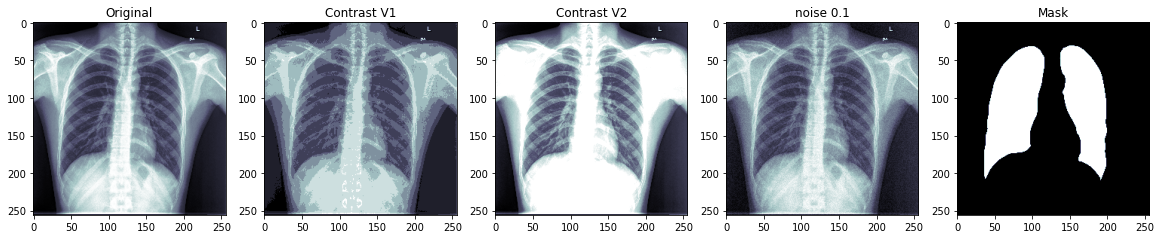

In [60]:
i = 13
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 10))

ax1.imshow(images[i].reshape(256, 256), cmap='bone')
ax1.set_title('Original')

ax2.imshow(contrast_images_v1[i].reshape(256, 256), cmap='bone')
ax2.set_title('Contrast V1')

ax3.imshow(contrast_images_v2[i].reshape(256, 256), cmap='bone')
ax3.set_title('Contrast V2')

ax4.imshow(noised_images[i].reshape(256, 256), cmap='bone')
ax4.set_title('noise 0.1')

ax5.imshow(masks[i].reshape(256, 256), cmap='bone')
ax5.set_title('Mask');

In [28]:
# Menggabungkan semua image dan semua label(mask)
all_images = np.concatenate((images, contrast_images_v1, contrast_images_v2, noised_images), axis=0)
all_masks  = np.concatenate((masks, masks, masks, masks), axis=0)

In [29]:
print('Dimensi/Ukuran dari semua Image: ',all_images.shape,'\nDimensi/Ukuran dari semua Label(Mask): ', all_masks.shape)

Dimensi/Ukuran dari semua Image:  (2816, 256, 256, 1) 
Dimensi/Ukuran dari semua Label(Mask):  (2816, 256, 256, 1)


In [30]:
# Ukuran Image = (256 x 256)
X_train, X_val, Y_train, Y_val = train_test_split((all_images - 127.0) / 127.0, 
                                                  (all_masks > 127).astype(np.float32), 
                                                  test_size = 0.2, 
                                                  random_state = 2018)
X_testNorm = (X_test - 127.0) / 127.0

# **4. Menerapkan Model XNet**

In [31]:
# Inisialisasi Fungsi
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jaccard_coef_loss(y_true, y_pred):
    return 1 - jaccard_coef(y_true, y_pred) 

In [32]:
# Code XNet dari github https://github.com/JosephPB/XNet
def XNet(input_shape=(256,256,1), classes=1, kernel_size = 3, filter_depth = (16,32,64,128,0)):
    img_input = Input(input_shape)
    
    # Encoder
    conv1 = Conv2D(filter_depth[0], (kernel_size, kernel_size), padding="same")(img_input)
    batch1 = BatchNormalization()(conv1)
    act1 = Activation("relu")(batch1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act1)
    #100x100
    
    conv2 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(pool1)
    batch2 = BatchNormalization()(conv2)
    act2 = Activation("relu")(batch2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act2)
    #50x50
    
    conv3 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(pool2)
    batch3 = BatchNormalization()(conv3)
    act3 = Activation("relu")(batch3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act3)
    #25x25
    
    #Flat
    conv4 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(pool3)
    batch4 = BatchNormalization()(conv4)
    act4 = Activation("relu")(batch4)
    #25x25
    
    conv5 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(act4)
    batch5 = BatchNormalization()(conv5)
    act5 = Activation("relu")(batch5)
    #25x25
    
    #Up
    up6 = UpSampling2D(size=(2, 2))(act5)
    conv6 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(up6)
    batch6 = BatchNormalization()(conv6)
    act6 = Activation("relu")(batch6)
    concat6 = Concatenate()([act3,act6])
    #50x50
    
    up7 = UpSampling2D(size=(2, 2))(concat6)
    conv7 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(up7)
    batch7 = BatchNormalization()(conv7)
    act7 = Activation("relu")(batch7)
    concat7 = Concatenate()([act2,act7])
    #100x100
    
    #Down
    conv8 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(concat7)
    batch8 = BatchNormalization()(conv8)
    act8 = Activation("relu")(batch8)
    pool8 = MaxPooling2D(pool_size=(2, 2))(act8)
    #50x50
    
    conv9 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(pool8)
    batch9 = BatchNormalization()(conv9)
    act9 = Activation("relu")(batch9)
    pool9 = MaxPooling2D(pool_size=(2, 2))(act9)
    
    #25x25
    
    #Flat
    conv10 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(pool9)
    batch10 = BatchNormalization()(conv10)
    act10 = Activation("relu")(batch10)
    #25x25
    
    conv11 = Conv2D(filter_depth[3], (kernel_size, kernel_size), padding="same")(act10)
    batch11 = BatchNormalization()(conv11)
    act11 = Activation("relu")(batch11)
    #25x25
    
    #Encoder
    up12 = UpSampling2D(size=(2, 2))(act11)
    conv12 = Conv2D(filter_depth[2], (kernel_size, kernel_size), padding="same")(up12)
    batch12 = BatchNormalization()(conv12)
    act12 = Activation("relu")(batch12)
    concat12 = Concatenate()([act9,act12])
    #50x50
    
    up13 = UpSampling2D(size=(2, 2))(concat12)
    conv13 = Conv2D(filter_depth[1], (kernel_size, kernel_size), padding="same")(up13)
    batch13 = BatchNormalization()(conv13)
    act13 =  Activation("relu")(batch13)
    concat13 = Concatenate()([act8,act13])
    #100x100
    
    up14 = UpSampling2D(size=(2, 2))(concat13)
    conv14 = Conv2D(filter_depth[0], (kernel_size, kernel_size), padding="same")(up14)
    batch14 = BatchNormalization()(conv14)
    act14 = Activation("relu")(batch14)
    concat14 = Concatenate()([act1,act14])
    #200x200
    
    conv15 = Conv2D(1, (1, 1), activation='sigmoid')(concat14)

    return Model(inputs=[img_input], outputs=[conv15])

In [33]:
# Inisialisasi XNet sebagai model yang akan digunakan
model = XNet(input_shape=(dim, dim, 1))

In [34]:
# Ringkasan Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [35]:
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=35) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [36]:
metrics = [dice_coef, jaccard_coef,
           'binary_accuracy', 
           tf.keras.metrics.Precision(), 
           tf.keras.metrics.Recall()]

loss = [dice_coef_loss, 
        jaccard_coef_loss,
        'binary_crossentropy']

In [37]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(lr = 1e-4), 
              loss = loss, 
              metrics = metrics)

*4.1. Train Model*

In [38]:
res = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=32, epochs=100,
                callbacks=callbacks_list)

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 0.4294 - dice_coef: 0.5714 - jaccard_coef: 0.4052 - binary_accuracy: 0.8384 - precision: 0.6331 - recall: 0.8630
Epoch 1: val_loss improved from inf to 0.66141, saving model to cxr_reg_weights.best.hdf5
71/71 [==============================] - 75s 816ms/step - loss: 0.4294 - dice_coef: 0.5714 - jaccard_coef: 0.4052 - binary_accuracy: 0.8384 - precision: 0.6331 - recall: 0.8630 - val_loss: 0.6614 - val_dice_coef: 0.3387 - val_jaccard_coef: 0.2039 - val_binary_accuracy: 0.6750 - val_precision: 0.3578 - val_recall: 0.3691 - lr: 1.0000e-04
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 0.3101 - dice_coef: 0.6901 - jaccard_coef: 0.5271 - binary_accuracy: 0.9351 - precision: 0.8348 - recall: 0.9280
Epoch 2: val_loss improved from 0.66141 to 0.63033, saving model to cxr_reg_weights.best.hdf5
71/71 [==============================] - 53s 746ms/step - loss: 0.3101 - dice_coef: 0.6901 - jaccard_coef: 0.5271

*4.2. Grafik setelah Train Model*

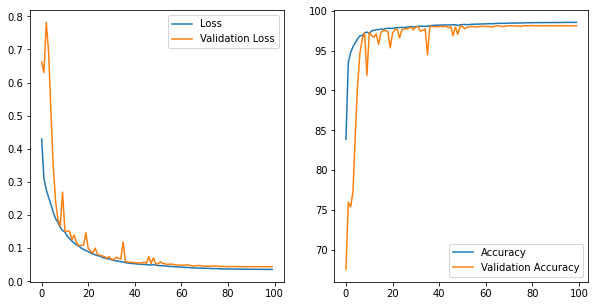

In [39]:
# Melihat grafik hubungan loss, validation loss dan accuracy, validation accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(res.history['loss'], '-', label = 'Loss')
ax1.plot(res.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(res.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(res.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

# **5. Melakukan Prediksi setelah Train Dataset**

*5.1. Prediksi dengan menggunakan sampel dari beberapa dataset Train yang sudah divalidasi*

In [40]:
preds_val = model.predict(X_val)

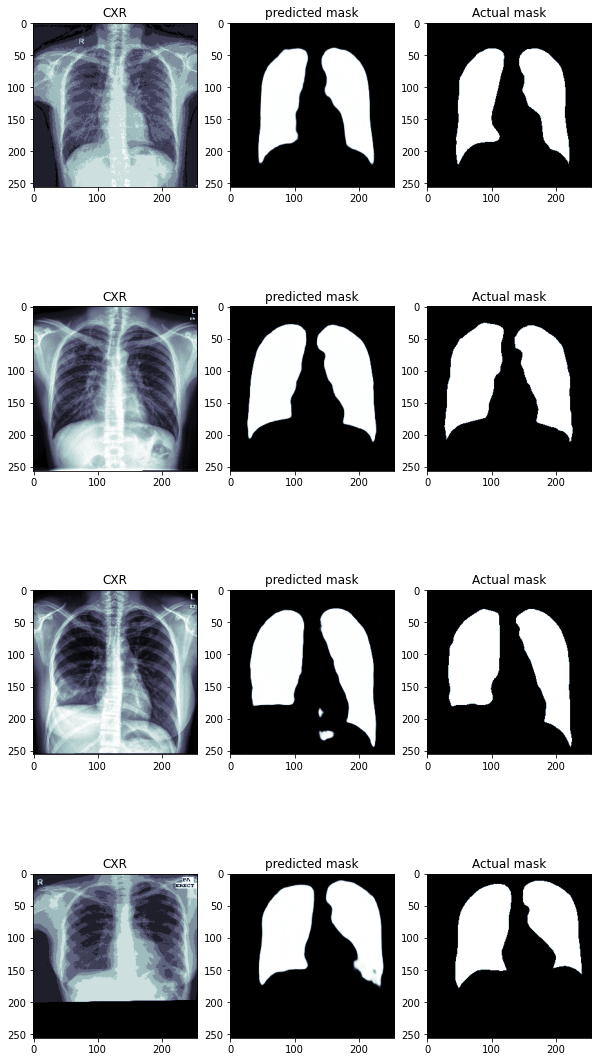

In [61]:
# Prediksi dari 4 gambar menggunakan Dataset Train yang sudah di validasi
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 20))

for i in range(4):
    for j in range(3):
        if j == 0:
            axs[i, j].imshow(X_val[i + 29].reshape(256, 256), cmap='bone')
            axs[i, j].set_title('CXR')
        elif j == 1:
            axs[i, j].imshow(preds_val[i + 29].reshape(256, 256), cmap='bone')
            axs[i, j].set_title('predicted mask')
       
        elif j == 2:
            axs[i, j].imshow(Y_val[i + 29].reshape(256, 256), cmap='bone')
            axs[i, j].set_title('Actual mask')

*5.2. Prediksi dengan menggunakan sampel dari beberapa dataset Test*

In [62]:
preds = model.predict(X_testNorm)

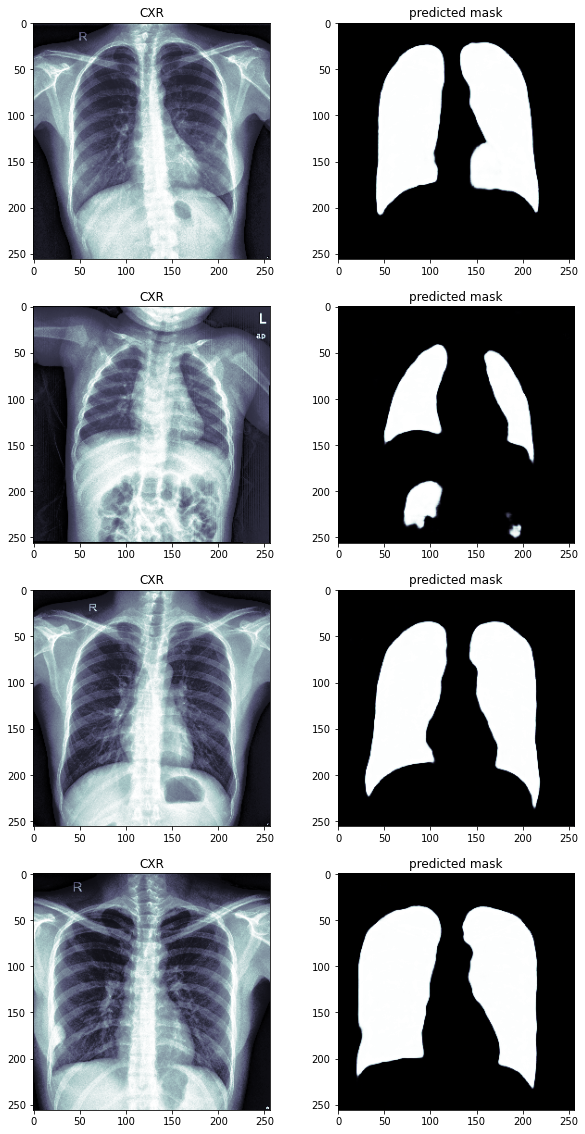

In [65]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for i in range(4):
    for j in range(2):
        if j != 1:
            axs[i, j].imshow(X_testNorm[i + 19].reshape(256, 256), cmap='bone')
            axs[i, j].set_title('CXR')
        else:
            axs[i, j].imshow(preds[i + 19].reshape(256, 256), cmap='bone')
            axs[i, j].set_title('predicted mask')